Projet de Théo Van Rooij et Mathieu Morgan

Nous avons choisi de réaliser un système de reconnaissance facial permettant de reconnaitre les acteurs principaux du marvel cinematic universe. Notre réseau reconnait les acteurs et non les noms des personnages joués (ex : Chris Evans au lieu de Captain America).
Afin de générer notre dataset, nous avons utilisés le site gettyimage et téléchargé toutes les images présentes sur la page de l'acteur sélectionné. Nous avons sélectionné deux pages par acteurs (ce qui donne une centaine d'image).

Les images sont ensuite stockés dans un dossier avec la même nomenclature que pour lors du TP 7.

Nous avons décidé de créer un nouveau Notebook sous les conseils de Mme Ouchtar afin d'avoir un rendu plus propre. Vous pouvez retrouver notre Tp7 et les débuts de notre projet avec le lien suivant :
 
https://colab.research.google.com/drive/1tfaItLev47CjsddgMfA47TUhw3czEMjo?usp=sharing



# Commençons par importer tous les modules nécessaires

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from google.colab.patches import cv2_imshow
import cv2
import dlib
import time
import os
from keras import layers
from keras import models
import sklearn
from sklearn.model_selection import train_test_split
import pickle
from keras.utils import to_categorical
import matplotlib.pyplot as plt

# 1. Importation des modèles prégénérés

Dans cette partie, nous allons importer les modèles prégénérés. Ces modèles comprennent ceux que vous nous avez fournis mais aussi deux modèles que nous avons générés : 


*   Notre réseau de neurone déjà entrainés sur notre dataset
*   Notre dataset stocké dans un fichier binaire



In [ ]:
!wget https://perso.esiee.fr/~vanrooit/FaceRecognition/models.zip
!unzip models.zip

--2021-04-22 19:19:30--  https://perso.esiee.fr/~vanrooit/FaceRecognition/models.zip
Resolving perso.esiee.fr (perso.esiee.fr)... 147.215.150.8
Connecting to perso.esiee.fr (perso.esiee.fr)|147.215.150.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208889095 (199M) [application/zip]
Saving to: ‘models.zip’

models.zip          100%[===================>] 199.21M  22.3MB/s    in 9.4s    

2021-04-22 19:19:40 (21.2 MB/s) - ‘models.zip’ saved [208889095/208889095]

Archive:  models.zip
   creating: models/
  inflating: models/avengersFacesEncoded  
  inflating: models/avengersModel.h5  
  inflating: models/dlib_face_recognition_resnet_model_v1.dat  
  inflating: models/mmod_human_face_detector.dat  
  inflating: models/shape_predictor_5_face_landmarks.dat  
  inflating: models/shape_predictor_68_face_landmarks.dat  


In [ ]:
# On charge le fichier généré précédemment
file = open("models/avengersFacesEncoded",'rb')
object_file = pickle.load(file)
file.close()

In [ ]:
# On extrait du fichier précédent toutes les variables utiles
faces=object_file[0]
encoded_faces=object_file[1]
labels_categorical=object_file[2]
labelsName=object_file[3]
labels = np.argmax(labels_categorical,axis=1)
print("Liste des acteurs disponibles : "+ str(labelsName))

Liste des acteurs disponibles : ['Chris_Evans', 'Chadwick_Boseman', 'Chris_Hemsworth', 'Jimmy_Fallon', 'Scarlett_Johansson', 'Sebastian_Stan', 'Jeremy_Renner', 'Jimmy_Kimmel', 'Tom_Holland', 'Ellen_Degeneres', 'Mark_Ruffalo', 'Samuel_L_Jackson', 'Benedict_Cumberbatch', 'Paul_Rudd', 'Natalie_Portman', 'Clark_Gregg', 'Robert_Downey_Jr', 'Elizabeth_Olsen', 'Don_Cheadle', 'Paul_Bettany', 'Gwyneth_Paltrow', 'Anthony_Mackie', 'Brie_Larson', 'Tom_Hiddleston', 'Chris_Pratt']


In [ ]:
#On charge le réseau de neurone
neural_network = models.load_model('models/avengersModel.h5')

Graces à ces modèles, à notre réseau déjà entrainé ainsi que le dataset avec les visages extraits et encodés, vous avez tout ce qu'il vous faut pour utiliser le réseau sur des cas concrets. Vous n'avez pas besoin de réextraire tous les visages et réentrainer le réseau de neurone. Vous pouvez donc passer directement à la partie 6. 

Attention, il vous faudra toutefois éxécutez les 
fonctions fournies de chaque parties car elles sont nécessaires au bon fonctionnement de la partie 6.

Vous pouvez également rééxécuter chacune des parties si vous souhaitez repartir de 0. Nous vous conseillons de commencer après l'extraction des visages car vous les avez d'ores et déjà récupéré dans les cellules précédentes et c'est une opération chronophage (environ une heure).

# 2. Extraction des visages

Afin de pouvoir réaliser notre réseau de neurones, nous devons commencer par extraire tous les visages de nos images. On va utiliser pour ça deux détecteur du module dlib :


*   hog_detector
*   cnn_detector

Le détecteur CNN est plus performant mais est plus couteux en ressource. Nous allons donc utiliser le "hog" car "cnn" consomme toute la mémoire de google collab.



## Fonctions fournies

In [ ]:
hog_detector = dlib.get_frontal_face_detector()
cnn_detector = dlib.cnn_face_detection_model_v1('models/mmod_human_face_detector.dat')

def face_locations(image, model="hog"):
    
    if model == "hog":
        detector = hog_detector
        cst = 0
    elif model == "cnn":
        detector = cnn_detector
        cst = 10
            
    matches = detector(image,1)
    rects   = []
    
    for r in matches:
        if model == "cnn":
            r = r.rect
        x = max(r.left(), 0)
        y = max(r.top(), 0)
        w = min(r.right(), image.shape[1]) - x + cst
        h = min(r.bottom(), image.shape[0]) - y + cst
        rects.append((x,y,w,h))
        
    return rects

In [ ]:
def extract_faces(image, model="hog"):
    
    gray  = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    rects = face_locations(gray, model)
    faces = []
    
    for (x,y,w,h) in rects:
        cropped = image[y:y+h, x:x+w, :]
        cropped = cv2.resize(cropped, (128,128))
        faces.append(cropped)
            
    return faces

In [ ]:
def show_grid(faces, figsize=(12,3)):

    n = len(faces)
    cols = 7
    rows = int(np.ceil(n/cols))
    
    fig, ax = plt.subplots(rows,cols, figsize=figsize)

    for r in range(rows):
        for c in range(cols):
            i = r*cols + c
            if i == n:
                 break
            ax[r,c].imshow(faces[i])
            ax[r,c].axis('off')
            #ax[r,c].set_title('size: ' + str(faces[i].shape[:2]))

In [ ]:
def list_images(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff","mp4"), contains=None):
    
    imagePaths = []
    
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                imagePaths.append(imagePath)
    
    return imagePaths

## Travail réalisé

On commence par importer toutes nos images.

In [ ]:
# IMPORT DU DATASET
!wget https://perso.esiee.fr/~vanrooit/FaceRecognition/avengersData.zip
!unzip avengersData.zip

Une fois que les images ont été importées, on peut extraire les visages présent sur chcune d'entre elle et y associé le bon label (dans notre cas le nom de l'acteur).

In [ ]:
imagePaths = list_images("data")

In [ ]:
start = time.time()
faces = []
labels=[]
for i,path in enumerate(imagePaths) :
  # Permet de suivre l'avancement
  print(str(i) + " / " + str(len(imagePaths)) + " " + path)
  image = cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  face = extract_faces(image, "hog") # CNN Pas fonctionnel => Consomme trop de ram
  if len(face)>0 :
    faces.append(face[0])
    labels.append(path.split("/")[1])
end = time.time()
# Permet d'afficher le temps total d'extraction
print("Temps d'extraction : " + str(end - start) + " secondes.")

Nos réseaux de neurones ne peuvent pas travailler avec des strings. On va donc devoir associer le nom d'une personne à un numéro et ensuite convertir cette entier vers une liste à l'aide de la fonction to_categorical.

Par exemple, si nous avons 5 sorties (5 acteurs possibles), le numéro 0 devient [1 0 0 0 0], 1 devient [0 1 0 0 0 ] etc.

Dans le même temps, nous allons créer une liste qui va contenir le nom de tous les acteurs possibles. Cela nous permettra par la suite d'associé le numéro de l'acteur avec son nom. Par exemple, si le réseau prédit que le visage présent sur l'image est l'acteur numéro 4, on obtient le nom de l'acteur correspondant à l'aide de labelsName[4].

In [ ]:
labelsName=[]
nbLabels=0
for i,label in enumerate(labels):
  if not label in labelsName :
    labelsName.append(label)
    labels[i] = nbLabels
    nbLabels +=1
  else :
    labels[i] = labelsName.index(label)

In [ ]:
labels_categorical = to_categorical(labels)

On peut afficher si on le souhaite le nombre de visages détectés pour chaque acteur.

In [ ]:
from collections import Counter
labels = np.argmax(labels_categorical,axis=1)
counterLabels = Counter(labels)
for label in counterLabels : 
  print(labelsName[label] + " : " + str(counterLabels[label]) + " images")

Chris_Evans : 103 images
Chadwick_Boseman : 93 images
Chris_Hemsworth : 97 images
Jimmy_Fallon : 67 images
Scarlett_Johansson : 104 images
Sebastian_Stan : 113 images
Jeremy_Renner : 106 images
Jimmy_Kimmel : 100 images
Tom_Holland : 105 images
Ellen_Degeneres : 75 images
Mark_Ruffalo : 98 images
Samuel_L_Jackson : 78 images
Benedict_Cumberbatch : 137 images
Paul_Rudd : 112 images
Natalie_Portman : 108 images
Clark_Gregg : 107 images
Robert_Downey_Jr : 113 images
Elizabeth_Olsen : 71 images
Don_Cheadle : 97 images
Paul_Bettany : 100 images
Gwyneth_Paltrow : 112 images
Anthony_Mackie : 124 images
Brie_Larson : 124 images
Tom_Hiddleston : 111 images
Chris_Pratt : 106 images


On peut maintenant passer ces visages dans un premier réseau. Ce réseau est un convnet car on va lui passer des images en inputs.

On va commencer par normaliser les visages extraits puis on va les séparer pour obtenir des datasets d'entrainement et de validation.

In [ ]:
faces_normalize=np.array(faces).astype('float32') / 255 # On normalise les images
train_images, test_images,train_labels,test_labels = train_test_split(faces_normalize,labels_categorical,test_size=0.3,train_size=0.7) # On split les images

### Entrainement du model

In [ ]:
input_dim=(128,128,3)

model = models.Sequential()

model.add( layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)) )

model.add( layers.MaxPooling2D((2, 2)) )

model.add( layers.Conv2D(64, (3, 3), activation='relu') )

model.add( layers.MaxPooling2D((2, 2)) )


model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))

#Il y a 25 acteurs donc 25 sorties
model.add(layers.Dense(25, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_images, train_labels,epochs=30,validation_data=(test_images,test_labels))

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print("Test accuracy:", test_acc*100, "%")

25/25 [==============================] - 0s 8ms/step - loss: 3.2827 - accuracy: 0.5956
Test accuracy: 59.5578670501709 %


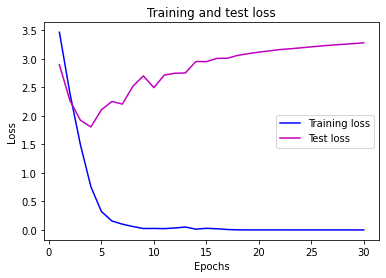

In [ ]:
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
train_loss = history.history['loss']
test_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_loss, linestyle='-', color='b', label='Training loss')
plt.plot(epochs, test_loss, linestyle='-', color='m', label='Test loss')

plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

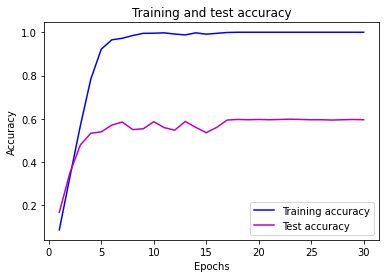

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs,  test_acc, 'm', label='Test accuracy')

plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Bien que l'accuracy pour le train tends vers 1, le modèle overfit : l'accuracy de test stagne vers 57 % et loss_test augmente fortement. Nous allons donc essayer d'améliorer le modèle actuel à l'aide des méthodes vues en cours.

### Amélioration du modèle

#### 2.1 Simplification du modèle


Nous avons vu qu'une des raisons à l'overfitting peut etre que le modèle est trop complexe. On va donc essayer de le simplifier en supprimant une des layers Conv2D.

In [ ]:
input_dim=(128,128,3)

simple_model = models.Sequential()

simple_model.add( layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)) )

simple_model.add( layers.MaxPooling2D((2, 2)) )

simple_model.add(layers.Flatten())

simple_model.add(layers.Dense(512, activation='relu'))
#Il y a 25 acteurs donc 25 sorties
simple_model.add(layers.Dense(25, activation='softmax'))

In [ ]:
simple_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

simple_history = simple_model.fit(train_images, train_labels,epochs=30,validation_data=(test_images,test_labels))

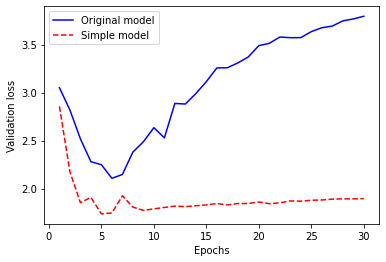

In [ ]:
plt.plot(epochs, history.history['val_loss'], linestyle='-', color='b', label='Original model')

plt.plot(epochs, simple_history.history['val_loss'], linestyle='--', color='r', label='Simple model')

plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

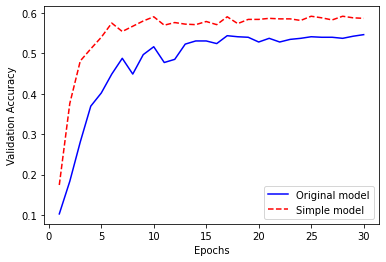

In [ ]:
plt.plot(epochs, history.history['val_accuracy'], linestyle='-', color='b', label='Original model')

plt.plot(epochs, simple_history.history['val_accuracy'], linestyle='--', color='r', label='Simple model')

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()

plt.show()

Cette solution semble relativement efficace. La perte du modèle simplifié est moins importante et l'accuracy est légèrement supérieure. 

Toutefois, ces valeurs ne sont toujours convaincante : une accuracy de 60% est trop faible et une perte de 2 est trop élevée. 

On va donc chercher d'autre techiniques pour réduire l'effet de l'overfitting.

#### 2.2 Norm Penalisation

Nous avons également vu que l'ajout de norm penalisation peut améliorer nos résultats. On va donc ajouter une pénalisation L2 sur la couche Dense pour voir l'effet sur notre modèle.

In [ ]:
from keras import regularizers
input_dim=(128,128,3)

regulazided_model = models.Sequential()

regulazided_model.add( layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_dim) )

regulazided_model.add( layers.MaxPooling2D((2, 2)) )

regulazided_model.add( layers.Conv2D(64, (3, 3), activation='relu') )

regulazided_model.add( layers.MaxPooling2D((2, 2)) )

regulazided_model.add(layers.Flatten())

regulazided_model.add(layers.Dense(64,kernel_regularizer=regularizers.l2(0.001), activation='relu'))
#Il y a 25 acteurs donc 25 sorties
regulazided_model.add(layers.Dense(25, activation='softmax'))

In [ ]:
regulazided_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

regulazided_history = regulazided_model.fit(train_images, train_labels,epochs=30,validation_data=(test_images,test_labels))

In [ ]:
plt.plot(epochs, history.history['val_loss'], linestyle='-', color='b', label='Original model')

plt.plot(epochs, simple_history.history['val_loss'], linestyle='--', color='r', label='Simple model')

plt.plot(epochs, regulazided_history.history['val_loss'], linestyle='--', color='g', label='L2-penalized model')

plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

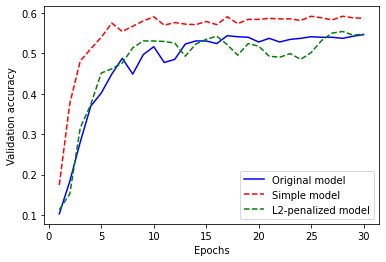

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, history.history['val_accuracy'], linestyle='-', color='b', label='Original model')

plt.plot(epochs, simple_history.history['val_accuracy'], linestyle='--', color='r', label='Simple model')

plt.plot(epochs, regulazided_history.history['val_accuracy'], linestyle='--', color='g', label='L2-penalized model')

plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.legend()

plt.show()


En ajoutant une pénalisation de type l2, le modèle est moins soumis à l'overfiting au niveau de la perte, même si elle reste élevée. En revanche, pour l'accuracy, les deux modèles semblent similaires.

Cependant, ce nouveau modèle est moins performant que le modèle simplifié. On ne retiendra donc pas la l2-penalisation

#### 2.3 Ajout de dropout


Dans cette partie, nous allons rajouter une couche de Dropout à la suite de la couche Dense. 

In [ ]:
from keras import regularizers
input_dim=(128,128,3)

dropout_model = models.Sequential()

dropout_model.add( layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_dim) )

dropout_model.add( layers.MaxPooling2D((2, 2)) )

dropout_model.add( layers.Conv2D(64, (3, 3), activation='relu') )

dropout_model.add( layers.MaxPooling2D((2, 2)) )

dropout_model.add(layers.Flatten())

dropout_model.add(layers.Dense(64, activation='relu'))
dropout_model.add(layers.Dropout(.5)) # ADD CODE HERE
#Il y a 25 acteurs donc 25 sorties
dropout_model.add(layers.Dense(25, activation='softmax'))

In [ ]:
dropout_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

dropout_history = dropout_model.fit(train_images, train_labels,epochs=30,validation_data=(test_images,test_labels))

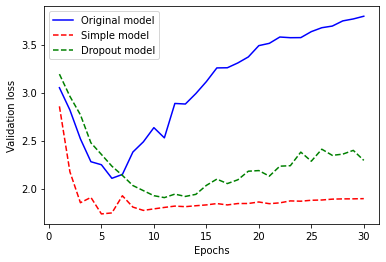

In [ ]:
plt.plot(epochs, history.history['val_loss'], linestyle='-', color='b', label='Original model')
plt.plot(epochs, simple_history.history['val_loss'], linestyle='--', color='r', label='Simple model')
plt.plot(epochs, dropout_history.history['val_loss'], linestyle='--', color='g', label='Dropout model')

plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

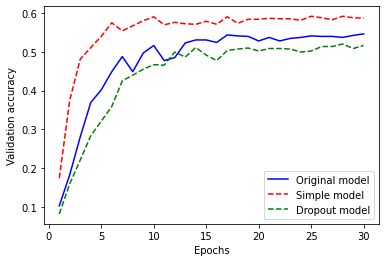

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, history.history['val_accuracy'], linestyle='-', color='b', label='Original model')

plt.plot(epochs, simple_history.history['val_accuracy'], linestyle='--', color='r', label='Simple model')

plt.plot(epochs, dropout_history.history['val_accuracy'], linestyle='--', color='g', label='Dropout model')

plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.legend()

plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print("Modèle original accuracy :", test_acc*100, "%\n")

test_loss, test_acc = simple_model.evaluate(test_images, test_labels)

print("Modèle simplifié accuracy :", test_acc*100, "%\n")

test_loss, test_acc = dropout_model.evaluate(test_images, test_labels)

print("Modèle dropout accuracy :", test_acc*100, "%")

25/25 [==============================] - 0s 8ms/step - loss: 3.8754 - accuracy: 0.5709
Modèle original accuracy : 57.08712339401245 %

25/25 [==============================] - 0s 8ms/step - loss: 1.8956 - accuracy: 0.5865
Modèle simplifié accuracy : 58.64759683609009 %

25/25 [==============================] - 0s 8ms/step - loss: 2.2941 - accuracy: 0.5163
Modèle dropout accuracy : 51.62549018859863 %


En observant les 2 derniers graphiques et la cellule précédente, on remarque que le modèle simplifié reste le meilleur de tout ceux que l'on a fait. Il permet d'améliorer l'accuracy de 1.5% et de faire chuter la perte significativement. 

On va donc retenir ce modèle comme étant le modèle le plus performants pour cette partie. On pourrait aussi arreter son entrainement après 6 epochs car c'est avec ce nombre que la perte est minimale et l'accuracy atteint sa valeur asymptotique.

#### 2.4 Augmentation du nombre d'images

Enfin, une autre raison à l'overfitting que nous avons vu en cours est le manque de données. Par conséquent, une solution à notre soucis serai donc augmenter le nombre d'images par personne. IL y a deux manières de faire ça :



*   Télécharger plus d'images
*   utiliser un générateur comme vu dans le tp 6.

Nous n'allons cependant pas mettre en place ces deux solutions car cela prendrai trop de temps. Dans les deux cas, il faut réaliser ces opérations dès le début du projet. Il faut utiliser les images avec visages non extraits. Ainsi, il faudrait, après générer de nouvelles images, extraire toutes les images. Sachant qu'il faut une heure pour extraire les visages avec notre nombre actuel d'image, le nouveau temps d'extraction serait bien trop important.

De plus, comme nos modèles n'ont que 60% d'accuracy, nous allons essayer de nouvelles méthodes pour améliorer notre modèle.



# 3. Recentrage des visages

Afin d'améliorer les résultats de notre modèle, nous allons recentrer les visages qui sont légèrement décentrés.

## Fonctions fournies

In [ ]:
pose68 = dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat')
pose05 = dlib.shape_predictor('models/shape_predictor_5_face_landmarks.dat')

def face_landmarks(face, model="large"):
    
    if model == "large":
        predictor = pose68
    elif model == "small":
        predictor = pose05
    
    if not isinstance(face, list):
        rect = dlib.rectangle(0,0,face.shape[1],face.shape[0])
        return predictor(face, rect)
    else:
        rect = dlib.rectangle(0,0,face[0].shape[1],face[0].shape[0])
        return [predictor(f,rect) for f in face]

In [ ]:
def shape_to_coords(shape):
    return np.float32([[p.x, p.y] for p in shape.parts()])

In [ ]:
TEMPLATE = np.float32([
    (0.0792396913815, 0.339223741112), (0.0829219487236, 0.456955367943),
    (0.0967927109165, 0.575648016728), (0.122141515615, 0.691921601066),
    (0.168687863544, 0.800341263616), (0.239789390707, 0.895732504778),
    (0.325662452515, 0.977068762493), (0.422318282013, 1.04329000149),
    (0.531777802068, 1.06080371126), (0.641296298053, 1.03981924107),
    (0.738105872266, 0.972268833998), (0.824444363295, 0.889624082279),
    (0.894792677532, 0.792494155836), (0.939395486253, 0.681546643421),
    (0.96111933829, 0.562238253072), (0.970579841181, 0.441758925744),
    (0.971193274221, 0.322118743967), (0.163846223133, 0.249151738053),
    (0.21780354657, 0.204255863861), (0.291299351124, 0.192367318323),
    (0.367460241458, 0.203582210627), (0.4392945113, 0.233135599851),
    (0.586445962425, 0.228141644834), (0.660152671635, 0.195923841854),
    (0.737466449096, 0.182360984545), (0.813236546239, 0.192828009114),
    (0.8707571886, 0.235293377042), (0.51534533827, 0.31863546193),
    (0.516221448289, 0.396200446263), (0.517118861835, 0.473797687758),
    (0.51816430343, 0.553157797772), (0.433701156035, 0.604054457668),
    (0.475501237769, 0.62076344024), (0.520712933176, 0.634268222208),
    (0.565874114041, 0.618796581487), (0.607054002672, 0.60157671656),
    (0.252418718401, 0.331052263829), (0.298663015648, 0.302646354002),
    (0.355749724218, 0.303020650651), (0.403718978315, 0.33867711083),
    (0.352507175597, 0.349987615384), (0.296791759886, 0.350478978225),
    (0.631326076346, 0.334136672344), (0.679073381078, 0.29645404267),
    (0.73597236153, 0.294721285802), (0.782865376271, 0.321305281656),
    (0.740312274764, 0.341849376713), (0.68499850091, 0.343734332172),
    (0.353167761422, 0.746189164237), (0.414587777921, 0.719053835073),
    (0.477677654595, 0.706835892494), (0.522732900812, 0.717092275768),
    (0.569832064287, 0.705414478982), (0.635195811927, 0.71565572516),
    (0.69951672331, 0.739419187253), (0.639447159575, 0.805236879972),
    (0.576410514055, 0.835436670169), (0.525398405766, 0.841706377792),
    (0.47641545769, 0.837505914975), (0.41379548902, 0.810045601727),
    (0.380084785646, 0.749979603086), (0.477955996282, 0.74513234612),
    (0.523389793327, 0.748924302636), (0.571057789237, 0.74332894691),
    (0.672409137852, 0.744177032192), (0.572539621444, 0.776609286626),
    (0.5240106503, 0.783370783245), (0.477561227414, 0.778476346951)])

TPL_MIN, TPL_MAX = np.min(TEMPLATE, axis=0), np.max(TEMPLATE, axis=0)
MINMAX_TEMPLATE = (TEMPLATE - TPL_MIN) / (TPL_MAX - TPL_MIN)

INNER_EYES_AND_BOTTOM_LIP = np.array([39, 42, 57])
OUTER_EYES_AND_NOSE = np.array([36, 45, 33])

In [ ]:
def align_faces(images, landmarks, idx=INNER_EYES_AND_BOTTOM_LIP):
    faces = []
    for (img, marks) in zip(images, landmarks):
        imgDim = img.shape[0]
        coords = shape_to_coords(marks)
        H = cv2.getAffineTransform(coords[idx], imgDim * MINMAX_TEMPLATE[idx])
        warped = cv2.warpAffine(img, H, (imgDim, imgDim))
        faces.append(warped)
    return faces

## Travail réalisé

In [ ]:
landmarks = face_landmarks(faces)

In [ ]:
aligned_faces = align_faces(faces, landmarks)

On peut maintenant réentrainé notre précédent Convnet pour voir si le résultat est plus staisfaisant.

In [ ]:
aligned_faces_normalize=np.array(aligned_faces).astype('float32') / 255 # On normalise les images
train_images, test_images,train_labels,test_labels = train_test_split(aligned_faces_normalize,labels_categorical,test_size=0.3,train_size=0.7) # On split les images

In [ ]:
model = models.Sequential()

model.add( layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_dim) )

model.add( layers.MaxPooling2D((2, 2)) )

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))

#Il y a 25 acteurs donc 25 sorties
model.add(layers.Dense(25, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_images, train_labels,epochs=30,validation_data=(test_images,test_labels))

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print("Test accuracy:", test_acc*100, "%")

25/25 [==============================] - 0s 10ms/step - loss: 0.7343 - accuracy: 0.8427
Test accuracy: 84.26527976989746 %


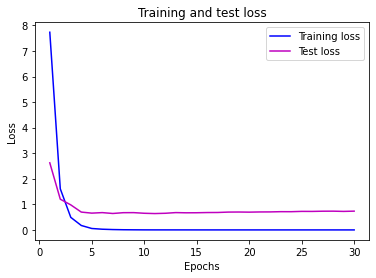

In [ ]:
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
train_loss = history.history['loss']
test_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_loss, linestyle='-', color='b', label='Training loss')
plt.plot(epochs, test_loss, linestyle='-', color='m', label='Test loss')

plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

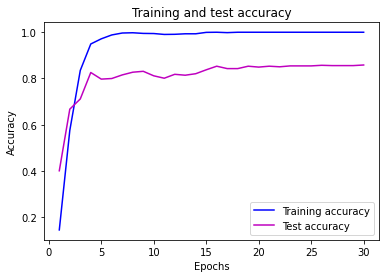

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs,  test_acc, 'm', label='Test accuracy')

plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

On peut tout de suite voir que recentrer les images a grandement amélioré notre modèle. L'accuracy pour le test est maintenant de 85 % contre 60% précédemment. 

On pourrait considérer une accuracy de 85% comme convenable mais nous souhaitons encore l'améliorer.

# 4. Encodage des visages

On va chercher à encoder les visages recentrés. Encoder un visage va revenir à extraires 128 mesures à partir du visage (couleurs des yeux, espacement des yeux ...). Cet encodage est réalisé à partir d'un des modèles fourni et retourne un vecteur de 128 valeurs. 

Comme nous avons un vecteur en entrée, nous n'avons plus besoin d'un convnet mais d'un simple neural network. 

In [ ]:
cnn_encoder = dlib.face_recognition_model_v1('models/dlib_face_recognition_resnet_model_v1.dat')

def face_encoder(faces):
    
    landmarks = face_landmarks(faces)
    
    if not isinstance(faces, list):
        return np.array(cnn_encoder.compute_face_descriptor(faces,landmarks))
    else:
        return np.array([cnn_encoder.compute_face_descriptor(f,l) for f,l in zip(faces,landmarks)])

In [ ]:
encoded_faces = face_encoder(aligned_faces)

Maintenant que nous avons extraits tous les visages, les labels et que nous les avons encodés, nous pouvons les sauvegardés dans un fichier binaire afin d'éviter de rééxécuter toutes les cellules précédentes.

In [ ]:
objectPickled = (faces,encoded_faces,labels_categorical,labelsName)
file = open("models/avengersFacesEncoded","wb")
pickle.dump(objectPickled,file)
file.close()

Maintenant  que l'on a extrait, rencentré et encodé les faces, on peut créer le réseau de neurones.

# 5. Création du réseau de neurone final

Nous avons maintenant encodés toutes les images. Il ne reste plus qu'à les passés dans notre neural network. 

In [ ]:
train_images, test_images,train_labels,test_labels = train_test_split(encoded_faces,labels_categorical,test_size=0.3,train_size=0.7) # On split les images

In [ ]:
neural_network = models.Sequential()
neural_network.add(layers.Dense(64, activation='relu', input_shape=(128,)))
neural_network.add(layers.Dense(25, activation='softmax')) # REMARK: softmax is for multi-class classification

In [ ]:
neural_network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = neural_network.fit(train_images, train_labels, epochs=50,validation_data=(test_images,test_labels))

In [ ]:
test_loss, test_acc = neural_network.evaluate(test_images, test_labels)
print("Test accuracy:", test_acc*100, "%")

25/25 [==============================] - 0s 2ms/step - loss: 0.1476 - accuracy: 0.9727
Test accuracy: 97.26918339729309 %


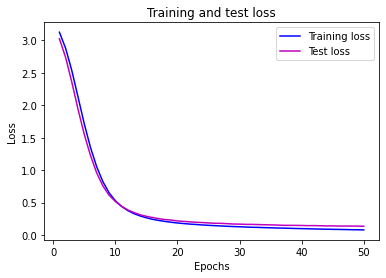

In [ ]:
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
train_loss = history.history['loss']
test_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_loss, linestyle='-', color='b', label='Training loss')
plt.plot(epochs, test_loss, linestyle='-', color='m', label='Test loss')

plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

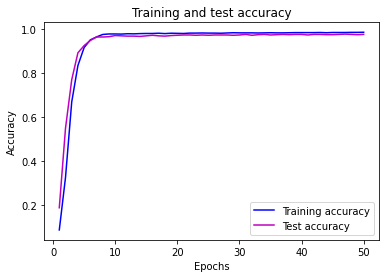

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs,  test_acc, 'm', label='Test accuracy')

plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Ce dernier réseau à une accuraccy de 98% et ne semble pas overfitté. On peut donc le consider comme satisfaisant et est le modèle que l'on va sauvegardé pour la suite.

In [ ]:
#On sauvegarde le modèle
neural_network.save('models/avengersModel.h5')

# 6. Utilisation de notre réseau sur des cas concret

Maintenant que notre modèle est entrainé et a des résultats satisfaisant, nous pouvons l'utiliser pour réaliser des prédictions sur des cas concrets. 

## Comparaison de classificateur

Nous commençons par comparer différents classificateur.

In [ ]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestCentroid
import time

In [ ]:
train_images, test_images,train_labels,test_labels = train_test_split(encoded_faces,labels,test_size=0.3,train_size=0.7) # On split les images

KNN


In [ ]:
clfKNN = NearestCentroid()
clfKNN.probability=True
clfKNN.fit(train_images, train_labels)
start = time.time()
print("score : ",clfKNN.score(test_images, test_labels))
end = time.time()
print("execution time of score ",end - start)

score :  0.9752925877763329
execution time of score  0.0067212581634521484


SVM

In [ ]:
clfSVM = svm.SVC()
clfSVM.fit(train_images, train_labels)
start = time.time()
print("score : ",clfSVM.score(test_images, test_labels))
end = time.time()
print("execution time of score ",end - start)

score :  0.9778933680104032
execution time of score  0.1859431266784668


Logistic Regression


In [ ]:
reg = LogisticRegression()
reg.fit(train_images, train_labels)
start = time.time()
print("score : ",reg.score(test_images, test_labels))
end = time.time()
print("execution time of score ",end - start)

score :  0.976592977893368
execution time of score  0.0014629364013671875


Comparaison de prédiction d'une image

In [ ]:
start = time.time()
print(labelsName[clfSVM.predict([test_images[190]])[0]])
end = time.time()
print("SVM : execution time of predict ",end - start)
start = time.time()
print(labelsName[clfKNN.predict([test_images[190]])[0]])
end = time.time()
print("KNN : execution time of predict ",end - start)
start = time.time()
print(labelsName[reg.predict([test_images[190]])[0]])
end = time.time()
print("Logistic : execution time of predict ",end - start)
start = time.time()
print(labelsName[neural_network.predict(test_images[190].reshape((1,128))).argmax()])
end = time.time()
print("Neural : execution time of predict ",end - start)

Robert_Downey_Jr
SVM : execution time of predict  0.004885435104370117
Robert_Downey_Jr
KNN : execution time of predict  0.001911163330078125
Robert_Downey_Jr
Logistic : execution time of predict  0.0002830028533935547
Robert_Downey_Jr
Neural : execution time of predict  0.03938555717468262


On remarque que tous les classificateurs ont environ le même score : entre 97 et 98 %. Ce n'est donc pas sur leur capacité à émettre une prédiction correcte que l'on va choisir quel modèle utilisé mais sur la vitesse à laquelle ils peuvent effectuer une prédiction. D'après la cellule précédente, le modèle le plus rapide est le Logistic Regression. Son temps à émettre une prédiction est suffisant afin d'appliquer notre système en temps réel sur une vidéo une vidéo à 60fps. 

En effet, il faut que le temps pour réaliser la prédiction soit inférieur à 1/60 = 0.017 s. C'est le cas pour pour le modèle régression (0.0016 s) mais ce n'est pas le cas pour notre réseau de neurone (0.051 s).

## Fonctions fournies

In [ ]:
def process_frame(image,probaLimit = 0,mode="fast",modele="reg"):
    # face detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if mode == "fast":
        matches = hog_detector(gray,1)
    else:
        matches = cnn_detector(gray,1)
        matches = [m.rect for m in matches]
   
    for rect in matches:
        
        # face landmarks
        landmarks = pose68(gray, rect)
        
        # face encoding
        encoding = np.array(cnn_encoder.compute_face_descriptor(image, landmarks))

        # face classification
        
        if modele == "reg" :
          prediction = reg.predict_proba([encoding])
        elif modele == "svm" :
          prediction = clfSVM.predict_proba([encoding])
        elif modele == "neural" :
          prediction = neural_network.predict(encoding.reshape((1,128)))
        else : 
          prediction = [0]
        label = labelsName[np.argmax(prediction)]
        proba = int(np.max(prediction)*100)
        displayLabel = str(proba) + " % : "+label

        if proba > probaLimit : # On évite d'afficher quand la prédiction n'est pas fiable. La proba limite est passée en paramètre
          # draw box
          cv2.rectangle(image, (rect.left(), rect.top()), (rect.right(), rect.bottom()), (0, 255, 0), 2)
          y = rect.top() - 15 if rect.top() - 15 > 15 else rect.bottom() + 25
          cv2.putText(image, displayLabel, (rect.left(), y), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 255, 0), 1)
        
    return image

In [ ]:
def process_movie(video_name,output_name,probaLimit=0, mode="fast",modele="reg"):
    
    start = time.time()
    video  = cv2.VideoCapture(video_name)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_name,fourcc, 60.0, (640,360))
    i=1
    try:
        
        while True:

            # Grab a single frame of video
            ret, frame = cv2.VideoCapture.read(video)

            # Resize frame of video for faster processing
            frame = cv2.resize(frame, (0, 0), fx=0.5, fy=0.5)

            # # Quit when the input video file ends or key "Q" is pressed
            key = cv2.waitKey(1) & 0xFF
            if not ret or key == ord("q"):
                break

            # Process frame
            image = process_frame(frame,probaLimit,mode,modele)
            # write the processed frame
            out.write(image)
            
            print(str(i) + " / " + str(10151))
            i+=1
            # Display the resulting image
            #cv2_imshow(image)
    
    finally:
        video.release()
        out.release()
        cv2.destroyAllWindows()

        print("Video released")
        
        end = time.time()
        print("Temps de traitement pour une vidéo de 2 min 50 :",end - start)
        

## Travail Réalisé

Pour réaliser des test, nous devons d'abord importer les données de test

In [ ]:
!wget https://perso.esiee.fr/~vanrooit/FaceRecognition/test.zip
!unzip test.zip

--2021-04-22 19:21:44--  https://perso.esiee.fr/~vanrooit/FaceRecognition/test.zip
Resolving perso.esiee.fr (perso.esiee.fr)... 147.215.150.8
Connecting to perso.esiee.fr (perso.esiee.fr)|147.215.150.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16697941 (16M) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[===================>]  15.92M  11.8MB/s    in 1.4s    

2021-04-22 19:21:45 (11.8 MB/s) - ‘test.zip’ saved [16697941/16697941]

Archive:  test.zip
  inflating: test/avengers.avi       
  inflating: test/avengers_1.JPG     


Nous allons commencer par réaliser une prédiction sur une photo.

Nous avons légèrement modifié la fonction process_image que vous nous avez fournis dans le TP7. Notre fonction permet de sauvegarder la vidéo avec reconnaissance faciale. Deplus, nous avons ajoutés un seuil de probabilité. Ce seuil permet de choisir si on préfère que le modèle soit sur de ces prédictions (auquel cas la probabilité est élevée) ou si on préfère que le modèle soit moins sûr de lui mais qu'il émette plus de prédictions (seuil proche de 0).

Nous avons également ajouté un le modèle que l'on souhaite utiliser en paramètre. La valeur est une chaine de caractère parmi celles suivantes : 


*   "neural" => Neural Network
*   "reg" => Regression Logistic
*   "svm" => SVN



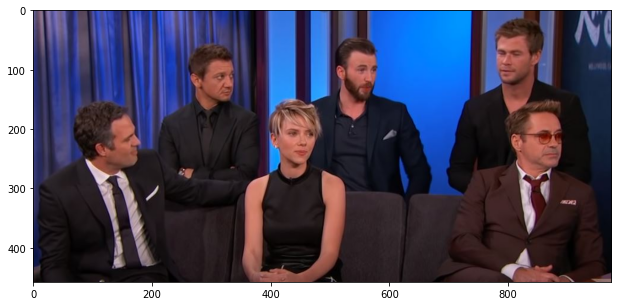

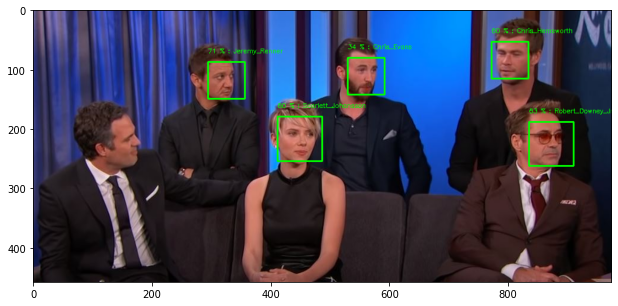

In [ ]:
image = cv2.imread("test/avengers_1.JPG")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,5))
plt.imshow(image)
processed = process_frame(image.copy(),modele="reg")
plt.figure(figsize=(15,5))
plt.imshow(processed)

Notre réseau semble fonctionné correctement. Tous les visages détectés ont étés correctement reconnus.

On peut donc appliquer notre modèle sur une vidéo. Notre vidéo est une interview de 6 acteurs par Jimmy Fallon

In [ ]:
process_movie("test/avengers.avi","/content/drive/MyDrive/avengersFaceRecognisedRegression.avi",probaLimit=0,modele="reg")

Vous pouvez visualiser la vidéo finale à l'adresse suivante suivante : https://www.youtube.com/watch?v=GXE0eZwKGZY

En regardant cette vidéo, on observe que les visages sont bien détectés et reconnu. En revanche, les probabillités ne sont pas très élevés. Ainsi, même si le modèle prédit corrctement, il n'est pas absolument sûr qu'elles sont exactes. Une  prédiction à 10% peut s'avérer correcte alors que certaines à 15 ne le sont pas. Il est difficile de fixer un seuil minimal de probabilité pour ce réseau. 

Essayons de voir comment performe le réseau de neurone sur la même vidéo. 

In [ ]:
process_movie("test/avengers.avi","/content/drive/MyDrive/avengersFaceRecognisedRegression.avi",probaLimit=0,modele="neural")

Vous pouvez visualiser la vidéo finale à l'adresse suivante suivante : 
[https://www.youtube.com/watch?v=4Elbj8wHiB8](https://www.youtube.com/watch?v=4Elbj8wHiB8)

On peut voir que les probabilités sont plus élevés pour le réseau de neurone. Ces prédictions sont plus fiables. On peut ainsi ajouter un seuil limite pour choisir si l'on veut plus de sureté sur les prédictions ou si l'on souhaite toutes les prendre.

### Probabilité minimale de 50%

In [ ]:
process_movie("test/avengers.avi","/content/drive/MyDrive/avengersFaceRecognised_50.avi",probaLimit=50,modele="neural")

Vous pouvez visualiser la vidéo finale à l'adresse suivante suivante : https://www.youtube.com/watch?v=fI8WXDv8x8w

### Probabilité minimale de 35%

In [ ]:
process_movie("test/avengers.avi","/content/drive/MyDrive/avengersFaceRecognised_35.avi",probaLimit=35,modele="neural")

Vous pouvez visualiser la vidéo finale à l'adresse suivante suivante : https://www.youtube.com/watch?v=risoZYEof1Y

### Choix de la probabilité limite pour le réseau neuronal

Comme vu avant, nous pouvons régler quelle est la probabilité que l'on juge acceptable. D'après les 3 vidéos précédentes, une probabilité de 35% semble être le bon compromis. 

### Conclusion : 

Pour appliquer notre système sur une vidéo en direct, la Régression Linéaire semble être la meilleure option. En revanche, pour une vidéo enregistré, le réseau de neurone semble être la meilleure option car il offre plus de personnalisation en réglant le seuil de probabilité. Cette option nécessite cependant plus de temps d'éxécution. 